# Classifying Voice Commands

Siri needs to be able to 
* figure out *what* the speaker wants
* *how* to accomplish that request






Project: Analyzing verbal commands to help Siri figure out what her correct response and action should be by: 

a) predicting the *intent* of the speaker

b) extracting interesting named entities within the command (NER)

**Named Entity Recognition** (NER):  locates and classifies entities in text into pre-defined categories such as person names, organizations, and locations.

<img src="https://miro.medium.com/max/2594/1*rq7FCkcq4sqUY9IgfsPEOg.png" width="500">

Part (a) -- sentence-level classification task,
 
Part (b) -- is a token-level classification task






## Data

Using a voice command dataset collected, annotated, and published by a French startup SNIPS.ai (which was [bought](https://investors.sonos.com/news-and-events/investor-news/latest-news/2019/Sonos-Announces-Acquisition-of-Snips/default.aspx) last November by Audio device manufacturer Sonos).

Preprocessed version of this dataset with token-level BIO tagging, (it is closer to the representation that our model will predict)

 This variant of the SNIPS dataset was prepared by [Su Zhu](https://github.com/sz128).

In [1]:
%tensorflow_version 2.x
%pip install -q transformers

from urllib.request import urlretrieve
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

SNIPS_DATA_BASE_URL = (
    "https://github.com/ogrisel/slot_filling_and_intent_detection_of_SLU/blob/"
    "master/data/snips/"
)
for filename in ["train", "valid", "test", "vocab.intent", "vocab.slot"]:
    path = Path(filename)
    if not path.exists():
      print(f"Downloading {filename}...")
      urlretrieve(SNIPS_DATA_BASE_URL + filename + "?raw=true", path)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 49.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 118.9 MB/s eta 0:00:00


Data: **five files** called "train", "valid", "test", "vocab.intent", and "vocab.slot".

The **intentions** our voice assistant can comprehend

In [2]:
# Prints vocab.intent
intent_lines = Path("vocab.intent").read_text().strip().splitlines()
for line in intent_lines:
  print(line)
print("\nThere are {} possible classes for the sentence level prediction task.".format(len(intent_lines)))

AddToPlaylist
BookRestaurant
GetWeather
PlayMusic
RateBook
SearchCreativeWork
SearchScreeningEvent

There are 7 possible classes for the sentence level prediction task.


Looking at 'vocab.slot' to see types of **named entities**

In [3]:
# Prints vocab.slot
slot_lines = Path("vocab.slot").read_text().strip().splitlines()
for line in slot_lines:
  print(line)
print("\nThere are {} possible classes for the word level prediction task.".format(len(slot_lines)))

B-album
B-artist
B-best_rating
B-city
B-condition_description
B-condition_temperature
B-country
B-cuisine
B-current_location
B-entity_name
B-facility
B-genre
B-geographic_poi
B-location_name
B-movie_name
B-movie_type
B-music_item
B-object_location_type
B-object_name
B-object_part_of_series_type
B-object_select
B-object_type
B-party_size_description
B-party_size_number
B-playlist
B-playlist_owner
B-poi
B-rating_unit
B-rating_value
B-restaurant_name
B-restaurant_type
B-served_dish
B-service
B-sort
B-spatial_relation
B-state
B-timeRange
B-track
B-year
I-album
I-artist
I-city
I-country
I-cuisine
I-current_location
I-entity_name
I-facility
I-genre
I-geographic_poi
I-location_name
I-movie_name
I-movie_type
I-music_item
I-object_location_type
I-object_name
I-object_part_of_series_type
I-object_select
I-object_type
I-party_size_description
I-playlist
I-playlist_owner
I-poi
I-restaurant_name
I-restaurant_type
I-served_dish
I-service
I-sort
I-spatial_relation
I-state
I-timeRange
I-track
O

There

### **BIO Tagging**

common format for tagging tokens in a NER task

B = beginning
I = inside
O = outside

```
      Book : O
         a : O
     table : O
       for : O
       two : B-party_size_number
        at : O
        Le : B-restaurant_name
         R : I-restaurant_name
     ##itz : I-restaurant_name
       for : O
    Friday : B-timeRange
     night : I-timeRange
         ! : O
```

### Reading in the training data stored in the "train" file

In [4]:
# Store all the training data in train_lines, and print only the first 3 lines of train_lines.
train_lines = Path("train").read_text().strip().splitlines()
i = 0
for line in train_lines:
  if (i<3):
    print(line)
    i+=1
  else:
    break

Add:O Don:B-entity_name and:I-entity_name Sherri:I-entity_name to:O my:B-playlist_owner Meditate:B-playlist to:I-playlist Sounds:I-playlist of:I-playlist Nature:I-playlist playlist:O <=> AddToPlaylist
put:O United:B-entity_name Abominations:I-entity_name onto:O my:B-playlist_owner rare:B-playlist groove:I-playlist playlist:O <=> AddToPlaylist
add:O the:O tune:B-music_item by:O misato:B-artist watanabe:I-artist to:O the:O Trapeo:B-playlist playlist:O <=> AddToPlaylist


In [5]:
train_lines = Path("train").read_text().strip().splitlines()
for line in train_lines[0:3]:
  print(line)

Add:O Don:B-entity_name and:I-entity_name Sherri:I-entity_name to:O my:B-playlist_owner Meditate:B-playlist to:I-playlist Sounds:I-playlist of:I-playlist Nature:I-playlist playlist:O <=> AddToPlaylist
put:O United:B-entity_name Abominations:I-entity_name onto:O my:B-playlist_owner rare:B-playlist groove:I-playlist playlist:O <=> AddToPlaylist
add:O the:O tune:B-music_item by:O misato:B-artist watanabe:I-artist to:O the:O Trapeo:B-playlist playlist:O <=> AddToPlaylist


**Format of the train data**:



*   The overall intent label for the voice command is at the end of the sequence, after the "<=>" separator.
*   Each word is annotated with a word-level token (BIO label), after the ":" separator.

### Ex 2

Parsing a line of training data into a [JSON](https://en.wikipedia.org/wiki/JSON) format to get the intent, length of the command, word-level BIO tags, and the command by itself. 

In [6]:
# Parsing a single line of training data into a JSON representation.
def parse_line(line):
    data, intent_label = line.split(" <=> ")
    items = data.split()
    words = [item.rsplit(":", 1)[0]for item in items]
    word_labels = [item.rsplit(":", 1)[1]for item in items]
    return {
        "intent_label": intent_label,
        "words": " ".join(words),
        "word_labels": word_labels,
        "length": len(line),
        "items": items
    }
    
parse_line(train_lines[0])

{'intent_label': 'AddToPlaylist',
 'words': 'Add Don and Sherri to my Meditate to Sounds of Nature playlist',
 'word_labels': ['O',
  'B-entity_name',
  'I-entity_name',
  'I-entity_name',
  'O',
  'B-playlist_owner',
  'B-playlist',
  'I-playlist',
  'I-playlist',
  'I-playlist',
  'I-playlist',
  'O'],
 'length': 200,
 'items': ['Add:O',
  'Don:B-entity_name',
  'and:I-entity_name',
  'Sherri:I-entity_name',
  'to:O',
  'my:B-playlist_owner',
  'Meditate:B-playlist',
  'to:I-playlist',
  'Sounds:I-playlist',
  'of:I-playlist',
  'Nature:I-playlist',
  'playlist:O']}

### Training Data Analysis

Using the ``parse_line`` function we completed to parse *all* the lines of the training data and store the results in a pandas DataFrame <img src="https://images.emojiterra.com/google/android-10/share/1f43c.jpg" width=40>

In [7]:
import pandas as pd

parsed_train = [parse_line(line) for line in train_lines]
df_train = pd.DataFrame([p for p in parsed_train if p is not None])
df_train

intent_label  \
0             AddToPlaylist   
1             AddToPlaylist   
2             AddToPlaylist   
3             AddToPlaylist   
4             AddToPlaylist   
...                     ...   
13079  SearchScreeningEvent   
13080  SearchScreeningEvent   
13081  SearchScreeningEvent   
13082  SearchScreeningEvent   
13083  SearchScreeningEvent   

                                                   words  \
0      Add Don and Sherri to my Meditate to Sounds of...   
1      put United Abominations onto my rare groove pl...   
2      add the tune by misato watanabe to the Trapeo ...   
3      add this artist to my this is miguel bosé play...   
4      add heresy and the hotel choir to the evening ...   
...                                                  ...   
13079  find a Consolidated Theatres showing The Good ...   
13080  where can i see animated movies in the neighbo...   
13081        Showtimes for animated movies in the area .   
13082  Which animated movies are playing at Megaplex ...   
13083             What movie schedules start at sunset ?   

                                             word_labels  length  \
0      [O, B-entity_name, I-entity_name, I-entity_nam...     200   
1      [O, B-entity_name, I-entity_name, O, B-playlis...     143   
2      [O, O, B-music_item, O, B-artist, I-artist, O,...     126   
3      [O, O, B-music_item, O, B-playlist_owner, B-pl...     150   
4      [O, B-entity_name, I-entity_name, I-entity_nam...     181   
...                                                  ...     ...   
13079  [O, O, B-location_name, I-location_name, O, B-...     190   
13080  [O, O, O, O, B-movie_type, I-movie_type, B-spa...     167   
13081  [O, O, B-movie_type, I-movie_type, B-spatial_r...     157   
13082  [O, B-movie_type, I-movie_type, O, O, O, B-loc...     174   
13083  [O, B-object_type, I-object_type, O, O, B-time...     111   

                                                   items  
0      [Add:O, Don:B-entity_name, and:I-entity_name, ...  
1      [put:O, United:B-entity_name, Abominations:I-e...  
2      [add:O, the:O, tune:B-music_item, by:O, misato...  
3      [add:O, this:O, artist:B-music_item, to:O, my:...  
4      [add:O, heresy:B-entity_name, and:I-entity_nam...  
...                                                  ...  
13079  [find:O, a:O, Consolidated:B-location_name, Th...  
13080  [where:O, can:O, i:O, see:O, animated:B-movie_...  
13081  [Showtimes:O, for:O, animated:B-movie_type, mo...  
13082  [Which:O, animated:B-movie_type, movies:I-movi...  
13083  [What:O, movie:B-object_type, schedules:I-obje...  

[13084 rows x 5 columns]

Same training data, but grouped by the sentence-level labels:

In [8]:
# Shows the number of sentences that belong to each class of the intent labels.
df_train.groupby("intent_label").count()[['words']]

words
intent_label               
AddToPlaylist          1842
BookRestaurant         1873
GetWeather             1900
PlayMusic              1900
RateBook               1856
SearchCreativeWork     1854
SearchScreeningEvent   1859

The spread of training examples according to sequence lengths now:

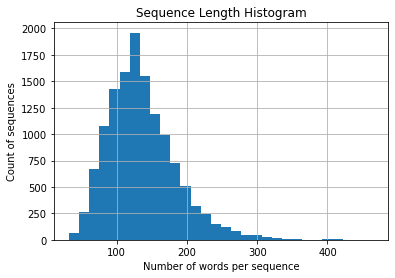

In [9]:
df_train.hist("length", bins=30)
plt.title("Sequence Length Histogram")
plt.xlabel("Number of words per sequence")
plt.ylabel("Count of sequences")
plt.show()

In [10]:
# Text representation of the histogram of sequence lengths.
count, division = np.histogram(df_train['length'], bins=30)

for i in range(len(count)):
  print("There are {} sequences that have between {} and {} number of words.".format(count[i], round(division[i],3), round(division[i+1],3)))

There are 63 sequences that have between 32.0 and 46.433 number of words.
There are 262 sequences that have between 46.433 and 60.867 number of words.
There are 669 sequences that have between 60.867 and 75.3 number of words.
There are 1078 sequences that have between 75.3 and 89.733 number of words.
There are 1424 sequences that have between 89.733 and 104.167 number of words.
There are 1584 sequences that have between 104.167 and 118.6 number of words.
There are 1960 sequences that have between 118.6 and 133.033 number of words.
There are 1550 sequences that have between 133.033 and 147.467 number of words.
There are 1190 sequences that have between 147.467 and 161.9 number of words.
There are 989 sequences that have between 161.9 and 176.333 number of words.
There are 726 sequences that have between 176.333 and 190.767 number of words.
There are 506 sequences that have between 190.767 and 205.2 number of words.
There are 316 sequences that have between 205.2 and 219.633 number of wo

What are the average and maximum sequence lengths within the training dataset?

In [11]:
avg_len = round(df_train['length'].mean(), 3)
print("Average sequence length: {} words per sequence".format(avg_len))

max_len = max(df_train['length'])
print("Maximum sequence length: {} words per sequence ".format(max_len))

Average sequence length: 136.069 words per sequence
Maximum sequence length: 465 words per sequence 


In [12]:
avg_len = round(df_train['length'].mean(), 3)
max_len = max(df_train['length'])
print("Maximum sequence length: {} words per sequence, average {} ".format(max_len, avg_len))

Maximum sequence length: 465 words per sequence, average 136.069 


### Ex 3

Creating a pandas DataFrames for the validation & test sets as well

* Reading in the validation and test data stored in the "valid" and "test" files

* Creating two DataFrames

In [13]:
# Read in the lines from 'valid' & 'test'
valid_lines = Path("valid").read_text().strip().splitlines()
test_lines = Path("test").read_text().strip().splitlines()

# create corresponding DataFrames called df_valid and df_test.
parsed_valid = [parse_line(line) for line in valid_lines]
df_valid = pd.DataFrame([p for p in parsed_valid if p is not None])

parsed_test = [parse_line(line) for line in test_lines]
df_test = pd.DataFrame([p for p in parsed_test if p is not None])

### Ex 4

* Number of total examples there are in each of the train, validation, and test sets

* Percentage breakdown of the total dataset across the train, val, and test sets

In [14]:
# How many datapoints are in each of the train, validation, & test Dataframes.
print("datapoints in train: {}".format(len(df_train)))
print("datapoints in validation: {}".format(len(df_valid)))
print("datapoints in test: {}".format(len(df_test)))

# Print the percentage of the total for each set.
total = len(df_train) + len(df_valid) + len(df_test)

datapoints in train: 13084
datapoints in validation: 700
datapoints in test: 700


We do not normally perform analysis on the validation and test sets, because the models we train should not be able to cheat and use information outside of the training set.

Number of sequences of each intent label class in each of the validation and training sets?

In [15]:
df_valid.groupby("intent_label").count()[['words']]

words
intent_label               
AddToPlaylist           100
BookRestaurant          100
GetWeather              100
PlayMusic               100
RateBook                100
SearchCreativeWork      100
SearchScreeningEvent    100

In [16]:
df_test.groupby("intent_label").count()[['words']]

words
intent_label               
AddToPlaylist           100
BookRestaurant          100
GetWeather              100
PlayMusic               100
RateBook                100
SearchCreativeWork      100
SearchScreeningEvent    100

There is exactly an even spread among the 7 sentence-level classes for both the validation and testing sets. 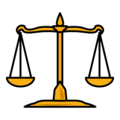